In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import cupy # CUDA interface for python
%load_ext autoreload
%autoreload 2
%load_ext autotime
import FastQSL

In [2]:
a = sciIO.readsav('../B0.sav')
print(a.keys())

C:\Users\Pjer1\Anaconda3\envs\torch15\lib\site-packages\scipy\io\idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


dict_keys(['twbox'])
time: 3.48 s


In [3]:
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.twbox[0].bx,(2,1,0)).astype(np.float32)
By = np.transpose(a.twbox[0].by,(2,1,0)).astype(np.float32)
Bz = np.transpose(a.twbox[0].bz,(2,1,0)).astype(np.float32)
(Bx_gpu,By_gpu,Bz_gpu) = [np.zeros(0) for _ in range(3)]; flag_init=False

time: 2.21 s


In [4]:
import numpy
import os

print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBlineAdaptive.cu", "rt")
TraceFunc =cupy.RawModule(code=traceFunc_file.read(),backend='nvcc',options=("-I "+PWD,))#, include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBline = TraceFunc.get_function("TraceAllBline")
#print('kernel compiled')

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = cupy.array(Bx)
    By_gpu = cupy.array(By)
    Bz_gpu = cupy.array(Bz)
    
dummy=cupy.zeros([1,1],dtype=cupy.float32)
flag_twist=cupy.array([False],dtype=cupy.bool_)

compiling kernel
transfering B-field to GPU
time: 8.39 s


In [50]:
# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
BshapeN = cupy.array(BshapeN)

interp_ratio=4
stride_step=1/interp_ratio
# full image
x_range = [0,1163]
y_range = [0,487]
# active region
#x_range = [350,670]
#y_range = [180,430]

x_i = cupy.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=cupy.float32)
y_i = cupy.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=cupy.float32)
x_arr,y_arr = cupy.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten()
y_inp = y_arr.flatten()
z_inp = (cupy.zeros_like(x_inp,cupy.float32)+0.0001# +23.583333
)
#z_inp[:] = +23.583333

if not flag_init:
    (x_start,y_start,z_start, x_end,y_end,z_end,
     Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
    )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    flag_init=True

line_len = cupy.zeros(x_inp.shape,cupy.float64)
N        = cupy.array([x_inp.shape[0]],cupy.ulonglong)
s_len    = cupy.array([1./8.],cupy.float32)
tol_coef = cupy.array([1.],cupy.float32)


inp_norm = cupy.array([0,0,1.],cupy.float32)

# for GTX 1060
# blck=(64,1,1)
# grd = (20,1)

# for GTX1080ti
blck=(128,1,1)
grd = (28,1)
cupy.cuda.stream.get_current_stream().synchronize()

time: 53 ms


In [51]:
#tol_coef_arr = cupy.array([1e2,1e1,1,0.1,0.01],dtype=cupy.float32)
tol_coef_arr = cupy.array([1],dtype=cupy.float32)
Qall_arr=cupy.zeros([*xy_shape,tol_coef_arr.shape[0]],dtype=cupy.float32)

time: 3.02 ms


In [52]:
import tqdm
for idx_tol,real_tol in tqdm.tqdm(enumerate(tol_coef_arr)):
    
    (x_start,y_start,z_start, x_end,y_end,z_end,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]
    (B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]
    
    
    x_inp = x_arr.flatten()
    y_inp = y_arr.flatten()
    z_inp = (cupy.zeros_like(x_inp,cupy.float32))
    # run the big calclation
    TraceAllBline(blck,grd,
                (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
                  dummy,dummy,dummy,dummy,flag_twist,
                x_inp,   y_inp,   z_inp,inp_norm,
                x_start, y_start, z_start, flag_start,
                x_end,   y_end,   z_end,   flag_end,
                Bx_inp,  By_inp,  Bz_inp,  B_flag,
                Bx_start,By_start,Bz_start,
                Bx_end,  By_end,  Bz_end,  
                s_len,N,line_len, real_tol))
    cupy.cuda.stream.get_current_stream().synchronize()

    (x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
     x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
     Bx_in_arr,   By_in_arr,  Bz_in_arr,
     Bx_out_arr,  By_out_arr, Bz_out_arr,
     Bx_0_arr,    By_0_arr,   Bz_0_arr,    B_flag_arr) = FastQSL.ResReshape(xy_shape,
                    x_end,y_end,z_end,flag_end,
                    x_start,y_start,z_start,flag_start,
                    Bx_start,By_start,Bz_start,
                    Bx_end,By_end,Bz_end,
                    Bx_inp,By_inp,Bz_inp,B_flag)
    Q=FastQSL.QCalcPlane(x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
         x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
         Bx_in_arr,   By_in_arr,  Bz_in_arr,
         Bx_out_arr,  By_out_arr, Bz_out_arr,
         Bx_0_arr,    By_0_arr,   Bz_0_arr,  
         B_flag_arr, stride_step)
    cupy.cuda.stream.get_current_stream().synchronize()


    stride_this  =  cupy.float32(1./interp_ratio)/8

    (cut_inp_x,   cut_inp_y,   cut_inp_z,
        cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
        cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
        Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
        Bx_start_cut,By_start_cut,Bz_start_cut,
        Bx_end_cut,  By_end_cut,  Bz_end_cut,  
        N_cut,line_len_cut,Bz0_start, Bz0_end)=FastQSL.CookPseudoLine(
             x_end_arr,   y_end_arr,  z_end_arr,   flag_end_arr,
             x_start_arr, y_start_arr,z_start_arr, flag_start_arr,
             Bx_in_arr,   By_in_arr,  Bz_in_arr,
             Bx_out_arr,  By_out_arr, Bz_out_arr,
             Bz_0_arr,    B_flag_arr, stride_this)

    # run the big calclation
    TraceAllBline(blck,grd,
                (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
                  dummy,dummy,dummy,dummy,flag_twist,
                cut_inp_x,   cut_inp_y,   cut_inp_z,inp_norm,
                cut_start_x, cut_start_y, cut_start_z,flag_cut_start,
                cut_end_x,   cut_end_y,   cut_end_z,  flag_cut_end,
                Bx_inp_cut,  By_inp_cut,  Bz_inp_cut,  B_flag_cut,
                Bx_start_cut,By_start_cut,Bz_start_cut,
                Bx_end_cut,  By_end_cut,  Bz_end_cut,  
                s_len,N_cut,line_len_cut, real_tol*.1))
    cupy.cuda.stream.get_current_stream().synchronize()


    (X1,Y1,X2,Y2) = [cupy.zeros(cut_inp_x.shape,dtype=cupy.float32) 
                     for _ in range(4)];

    idx_Z1_cut=(flag_cut_start-1)//2 == 2;  idx_Z2_cut=(flag_cut_end-1)//2 == 2
    idx_Y1_cut=(flag_cut_start-1)//2 == 1;  idx_Y2_cut=(flag_cut_end-1)//2 == 1
    idx_X1_cut=(flag_cut_start-1)//2 == 0;  idx_X2_cut=(flag_cut_end-1)//2 == 0

    # Z plane
    X1[idx_Z1_cut] = cut_start_x[idx_Z1_cut]; Y1[idx_Z1_cut] = cut_start_y[idx_Z1_cut] 
    X2[idx_Z2_cut] = cut_end_x[idx_Z2_cut];   Y2[idx_Z2_cut] = cut_end_y[idx_Z2_cut] 
    # Y plane
    X1[idx_Y1_cut] = cut_start_z[idx_Y1_cut]; Y1[idx_Y1_cut] = cut_start_x[idx_Y1_cut]
    X2[idx_Y2_cut] = cut_end_z[idx_Y2_cut];   Y2[idx_Y2_cut] = cut_end_x[idx_Y2_cut]
    # X plane
    X1[idx_X1_cut] = cut_start_y[idx_X1_cut]; Y1[idx_X1_cut] = cut_start_z[idx_X1_cut]
    X2[idx_X2_cut] = cut_end_y[idx_X2_cut];   Y2[idx_X2_cut] = cut_end_z[idx_X2_cut]

    dx2xc = X2[0::4]-X2[2::4]; dx2yc = X2[1::4]-X2[3::4];
    dy2xc = Y2[0::4]-Y2[2::4]; dy2yc = Y2[1::4]-Y2[3::4];

    dx1xc = X1[0::4]-X1[2::4]; dx1yc = X1[1::4]-X1[3::4];
    dy1xc = Y1[0::4]-Y1[2::4]; dy1yc = Y1[1::4]-Y1[3::4];

    a_cut = (dx2xc*dy1yc-dx2yc*dy1xc);
    b_cut = (dx2yc*dx1xc-dx2xc*dx1yc);
    c_cut = (dy2xc*dy1yc-dy2yc*dy1xc);
    d_cut = (dy2yc*dx1xc-dy2xc*dx1yc);

    bnr_cut = cupy.abs(Bz0_end)/(cupy.abs(Bz0_start))*((1/stride_this/2)**4)
    Qcut = (a_cut**2+b_cut**2+c_cut**2+d_cut**2)*bnr_cut
    Qcut[cupy.where(Qcut<1.0)]=1.0


    Q_all=cupy.zeros(x_end_arr.shape,dtype=cupy.float32)

    Q_all[1:-1,1:-1]=Q
    Q_all[B_flag_arr==1]=Qcut
    Q_final=Q_all[1:-1,1:-1]

    Qall_arr[:,:,idx_tol]=Q_all
    
    cupy.cuda.stream.get_current_stream().synchronize()
    (x_start,y_start,z_start, x_end,y_end,z_end,z_inp,
         Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
        )=[None for _ in range(16)]
    (B_flag,flag_start,flag_end)=[None for _ in range(3)]

1it [00:02,  2.22s/it]

time: 2.23 s


<ipython-input-49-a383a3baeecd>:11: RuntimeWarning: divide by zero encountered in log10
  ax0.imshow(np.log10(Qall_arr[:,:,0].get())*np.sign(Bz_0_arr.get()),
<ipython-input-49-a383a3baeecd>:19: RuntimeWarning: divide by zero encountered in log10
  ax1.imshow(np.log10(Qall_arr[:,:,1].get())*np.sign(Bz_0_arr.get()),
<ipython-input-49-a383a3baeecd>:28: RuntimeWarning: divide by zero encountered in log10
  ax2.imshow(np.log10(Qall_arr[:,:,2].get())*np.sign(Bz_0_arr.get()),
<ipython-input-49-a383a3baeecd>:36: RuntimeWarning: divide by zero encountered in log10
  ax3.imshow(np.log10(Qall_arr[:,:,3].get())*np.sign(Bz_0_arr.get()),


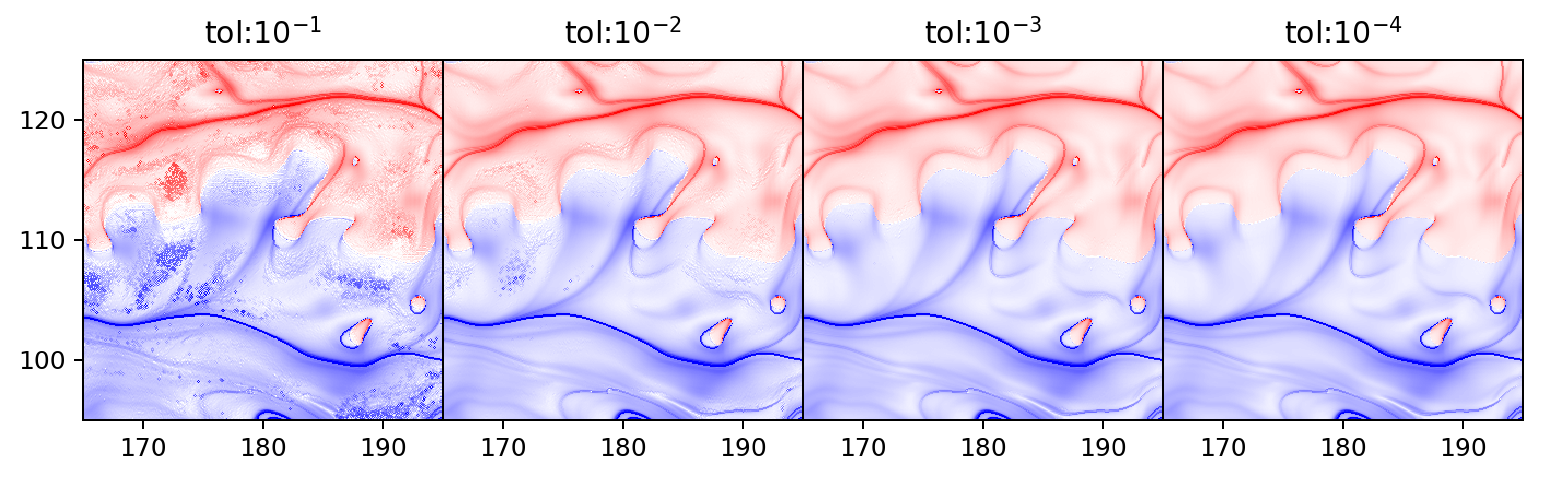

time: 1.72 s


In [49]:
x_range_real = np.array(x_range)*axis_r
y_range_real = np.array(y_range)*axis_r

fig=plt.figure(13,dpi=dpi,figsize=[8,2]);

ax0 = fig.add_axes([0,0,1/4,1])
ax1 = fig.add_axes([1/4,0,1/4,1])
ax2 = fig.add_axes([2/4,0,1/4,1])
ax3 = fig.add_axes([3/4,0,1/4,1])

ax0.imshow(np.log10(Qall_arr[:,:,0].get())*np.sign(Bz_0_arr.get()),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range_real,*y_range_real])
ax0.set_xlim([165,195])
ax0.set_ylim([95,125])
ax0.axes.get_xaxis().set_ticks([170,180,190])
ax0.axes.get_yaxis().set_ticks([100,110,120])

ax1.imshow(np.log10(Qall_arr[:,:,1].get())*np.sign(Bz_0_arr.get()),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range_real,*y_range_real])
ax1.set_xlim([165,195])
ax1.set_ylim([95,125])
ax1.axes.get_xaxis().set_ticks([170,180,190])
ax1.axes.get_yaxis().set_ticks([])


ax2.imshow(np.log10(Qall_arr[:,:,2].get())*np.sign(Bz_0_arr.get()),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range_real,*y_range_real])
ax2.set_xlim([165,195])
ax2.set_ylim([95,125])
ax2.axes.get_xaxis().set_ticks([170,180,190])
ax2.axes.get_yaxis().set_ticks([])

ax3.imshow(np.log10(Qall_arr[:,:,3].get())*np.sign(Bz_0_arr.get()),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',
                extent=[*x_range_real,*y_range_real])
ax3.set_xlim([165,195])
ax3.set_ylim([95,125])
ax3.axes.get_xaxis().set_ticks([170,180,190])
ax3.axes.get_yaxis().set_ticks([])

ax0.set_title(r'tol:$\rm{10^{-1}}$')
ax1.set_title(r'tol:$\rm{10^{-2}}$')
ax2.set_title(r'tol:$\rm{10^{-3}}$')
ax3.set_title(r'tol:$\rm{10^{-4}}$')

fig.savefig('tol.pdf',bbox_inches='tight',pad_inches=0.1)